In [1]:
import os
import chromadb
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

In [2]:
ROOT = 'data'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))
HNSW_SPACE = "hnsw:space"

In [3]:
def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = path + "/" + label
        filenames = os.listdir(label_path)
        for filename in filenames:
            filepath = label_path + '/' + filename
            files_path.append(filepath)
    return files_path

In [4]:
data_path = f'{ROOT}/train'
files_path = get_files_path(path=data_path)
files_path

['data/train/African_crocodile/n01697457_10393.JPEG',
 'data/train/African_crocodile/n01697457_104.JPEG',
 'data/train/African_crocodile/n01697457_1331.JPEG',
 'data/train/African_crocodile/n01697457_14906.JPEG',
 'data/train/African_crocodile/n01697457_18587.JPEG',
 'data/train/African_crocodile/n01697457_260.JPEG',
 'data/train/African_crocodile/n01697457_5586.JPEG',
 'data/train/African_crocodile/n01697457_8136.JPEG',
 'data/train/African_crocodile/n01697457_8331.JPEG',
 'data/train/African_crocodile/n01697457_85.JPEG',
 'data/train/American_egret/n02009912_1358.JPEG',
 'data/train/American_egret/n02009912_13895.JPEG',
 'data/train/American_egret/n02009912_15872.JPEG',
 'data/train/American_egret/n02009912_16896.JPEG',
 'data/train/American_egret/n02009912_26245.JPEG',
 'data/train/American_egret/n02009912_36395.JPEG',
 'data/train/American_egret/n02009912_4403.JPEG',
 'data/train/American_egret/n02009912_5700.JPEG',
 'data/train/American_egret/n02009912_7609.JPEG',
 'data/train/Ame

In [5]:
def plot_results(image_path, files_path, results):
    query_image = Image.open(image_path).resize((448,448))
    images = [query_image]
    class_name = []
    for id_img in results['ids'][0]:
        id_img = int(id_img.split('_')[-1])
        img_path = files_path[id_img]
        img = Image.open(img_path).resize((448,448))
        images.append(img)
        class_name.append(img_path.split('/')[2])

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Iterate through images and plot them
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        if i == 0:
            ax.set_title(f"Query Image: {image_path.split('/')[2]}")
        else:
            ax.set_title(f"Top {i+1}: {class_name[i-1]}")
        ax.axis('off')  # Hide axes
    # Display the plot
    plt.show()

### Image Embedding

In [6]:
embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=np.array(image))
    return embedding

e:\Anaconda\envs\anhHop\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
img = Image.open('data/train/African_crocodile/n01697457_260.JPEG')
get_single_image_embedding(image=img)

[0.020754072815179825,
 0.016990460455417633,
 -0.054690614342689514,
 0.019304169341921806,
 0.00039220115286298096,
 0.012462875805795193,
 -0.01630200259387493,
 -0.002161245560273528,
 0.05082112178206444,
 0.01321033388376236,
 -0.012080434709787369,
 0.007768881507217884,
 0.018878217786550522,
 -0.03940121456980705,
 0.011419863440096378,
 0.022976025938987732,
 -0.06463559716939926,
 0.026433052495121956,
 0.01486839260905981,
 0.0026927166618406773,
 -0.04405170679092407,
 -0.006424818653613329,
 0.0056815980933606625,
 -0.030825240537524223,
 -0.016431588679552078,
 -0.0003303247212897986,
 0.0053351144306361675,
 -0.015247104689478874,
 -0.007788191083818674,
 -0.02552957460284233,
 -0.012696832418441772,
 0.019195664674043655,
 0.0023741936311125755,
 0.014718917198479176,
 -0.027008945122361183,
 -0.03939792141318321,
 0.015397491864860058,
 -0.014291277155280113,
 -0.03243488073348999,
 0.01033446192741394,
 -0.01655704900622368,
 0.04119966924190521,
 -0.0355012230575084

## Chromadb L2 Embedding Collection

In [8]:
def add_embedding(collection, files_path):
    ids = []
    embeddings = []
    for id_filepath, filepath in tqdm(enumerate(files_path)):
        ids.append(f'id_{id_filepath}')
        image = Image.open(filepath)
        embedding = get_single_image_embedding(image=image)
        embeddings.append(embedding)
    collection.add(
        embeddings=embeddings,
        ids=ids
    )

In [9]:
# Create a Chroma Client
chroma_client = chromadb.Client()
# Create a collection
l2_collection = chroma_client.get_or_create_collection(name="l2_collection",
                                                           metadata={HNSW_SPACE: "l2"})
add_embedding(collection=l2_collection, files_path=files_path)

595it [02:28,  3.99it/s]


## Search Image With L2 Collection

In [10]:
def search(image_path, collection, n_results):
    query_image = Image.open(image_path)
    query_embedding = get_single_image_embedding(query_image)
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results # how many results to return
    )
    return results

In [11]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
l2_results = search(image_path=test_path, collection=l2_collection, n_results=5)

In [12]:
l2_results

{'ids': [['id_14', 'id_19', 'id_16', 'id_18', 'id_11']],
 'distances': [[0.4049466848373413,
   0.41377532482147217,
   0.5006763935089111,
   0.5080232620239258,
   0.5198466777801514]],
 'metadatas': [[None, None, None, None, None]],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

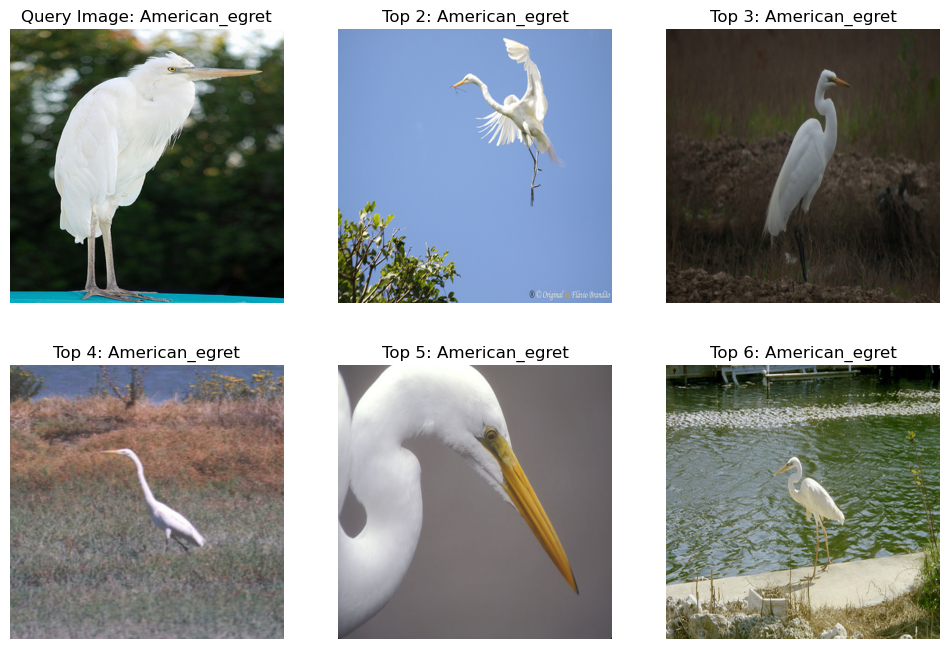

In [13]:
plot_results(image_path=test_path, files_path=files_path, results=l2_results)

## Search Image With Cosine similarity Collection

In [14]:
# Create a collection
cosine_collection = chroma_client.get_or_create_collection(name="Cosine_collection",
                                                           metadata={HNSW_SPACE: "cosine"})
add_embedding(collection=cosine_collection, files_path=files_path)

595it [02:34,  3.86it/s]


In [15]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
cosine_results = search(image_path=test_path, collection=cosine_collection, n_results=5)

In [16]:
cosine_results

{'ids': [['id_14', 'id_19', 'id_16', 'id_18', 'id_11']],
 'distances': [[0.20247340202331543,
   0.2068878412246704,
   0.2503383755683899,
   0.2540115714073181,
   0.2599233388900757]],
 'metadatas': [[None, None, None, None, None]],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

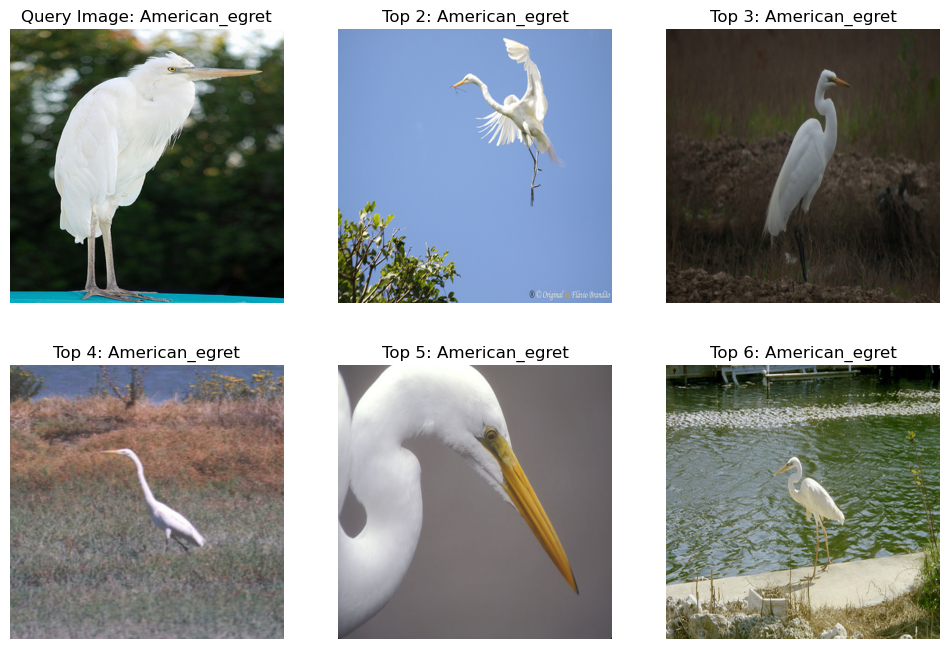

In [17]:
plot_results(image_path=test_path, files_path=files_path, results=cosine_results)